This file contains the results of one experiment, which used Flair as the POS tagger and TF-IDF for text conversion.

In [2]:
import pandas as pd
import regex as re
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from flair.models import SequenceTagger
from flair.data import Sentence

c:\Users\User\Documents\Code\env\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
df = pd.read_csv('data/clean/clean_dataset_posBERTV1.csv')
df.head()

name  \
0   Gamis Pria Dewasa Premium / Jubah Pakistan Polos   
1  Buket Bunga Mawar Flanel / Bunga wisuda / Bung...   
2  Mika Sen Depan Supra Fit New Kaca Lampu Sein D...   
3  Blazer wanita jumbo big size stik balik / plus...   
4  Buku Ilmu Sosial Budaya Dasar Perspektif Baru ...   

                                    multiCorpus_noun  name_length  \
0                        pria premium jubah pakistan           12   
1  buket bunga mawar flanel bunga wisuda bunga so...           17   
2      mika depan fit new kaca lampu dpn motor bebek           20   
3                 blazer wanita jumbo size plus size           22   
4                  buku ilmu sosial budaya kesadaran            4   

                           multiCorpus_noun_rm10  \
0                                   pria premium   
1  buket bunga mawar bunga wisuda bunga souvenir   
2            mika fit new kaca lampu motor bebek   
3                  blazer wanita jumbo size size   
4                               buku ilmu sosial   

            multiCorpus_noun_rm20   multiCorpus_noun_rm30  \
0                    pria premium            pria premium   
1      bunga bunga bunga souvenir       bunga bunga bunga   
2  fit new kaca lampu motor bebek    new kaca lampu motor   
3   blazer wanita jumbo size size  wanita jumbo size size   
4                            buku                    buku   

    multiCorpus_noun_rm40  
0            pria premium  
1       bunga bunga bunga  
2    new kaca lampu motor  
3  wanita jumbo size size  
4                    buku

In [4]:
# list of range for the number of clusters
range_list = [range(2, 20), range(100, 120), range(500, 520), range(1000, 1020)]

# list of vectorizers
vectorizers = {
    'original noun': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun']),
    'noun remove-10': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm10']),
    'noun remove-20': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm20']),
    'noun remove-30': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm30']),
    'noun remove-40': TfidfVectorizer(max_df=0.95, stop_words='english').fit_transform(df['multiCorpus_noun_rm40'])
}

# list for storing the results
results = [] 

In [5]:
def clustering_experiment(range_list):
    for name, data in vectorizers.items():
        for cluster_range in range_list:
            silhouette_scores = []
            # K-Means clustering
            for n_clusters in cluster_range:
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                labels = kmeans.fit_predict(data)
                score = silhouette_score(data, labels)
                silhouette_scores.append(score)
            
            # store the results
            avg_score = sum(silhouette_scores) / len(silhouette_scores)
            best_score = max(silhouette_scores)
            results.append({
                'model_noun': name,
                'cluster_range': f"{cluster_range.start}-{cluster_range.stop - 1}",
                'avg_silhouette_score': avg_score,
                'best_silhouette_score': best_score
            })

# run the experiment
clustering_experiment(range_list)

### Analysis Experiment Results

In [6]:
# convert the results to a DataFrame for visualization
results_df = pd.DataFrame(results)

In [7]:
results_df.head()

model_noun cluster_range  avg_silhouette_score  best_silhouette_score
0   original noun          2-19              0.005756               0.009072
1   original noun       100-119              0.021743               0.022147
2   original noun       500-519              0.036259               0.036492
3   original noun     1000-1019              0.045718               0.045828
4  noun remove-10          2-19              0.015015               0.023896

### Box plot to visualize the distribution of silhouette scores by preprocessing method

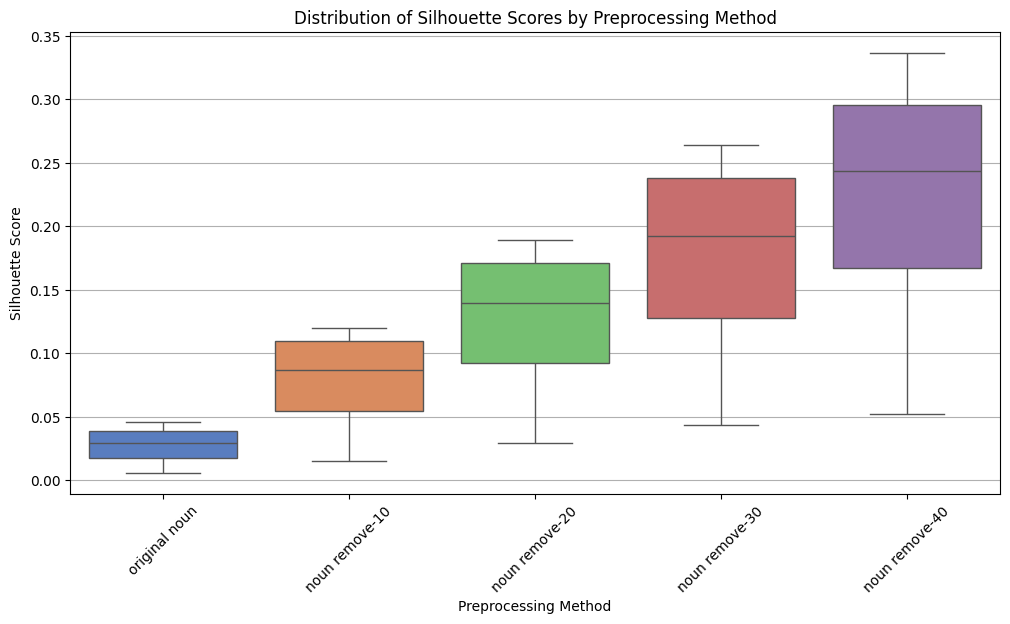

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=results_df,
    x='model_noun',
    y='avg_silhouette_score',
    palette='muted',
    hue='model_noun'
)
plt.title("Distribution of Silhouette Scores by Preprocessing Method")
plt.xlabel("Preprocessing Method")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


### Line plot to visualize the trend of silhouette scores over cluster range

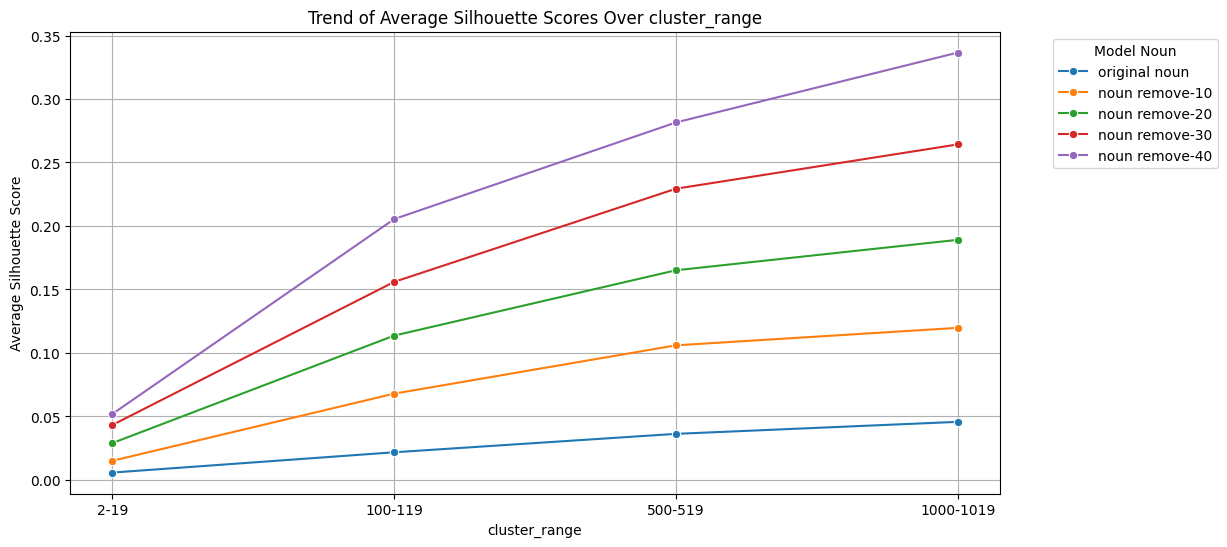

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x='cluster_range',
    y='avg_silhouette_score',
    hue='model_noun',
    marker='o',
    palette='tab10'
)
plt.title("Trend of Average Silhouette Scores Over cluster_range")
plt.xlabel("cluster_range")
plt.ylabel("Average Silhouette Score")
plt.legend(title="Model Noun", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


### Facet grid plot to visualize the distribution of best silhoutte scores over cluster range for each preprocessing method

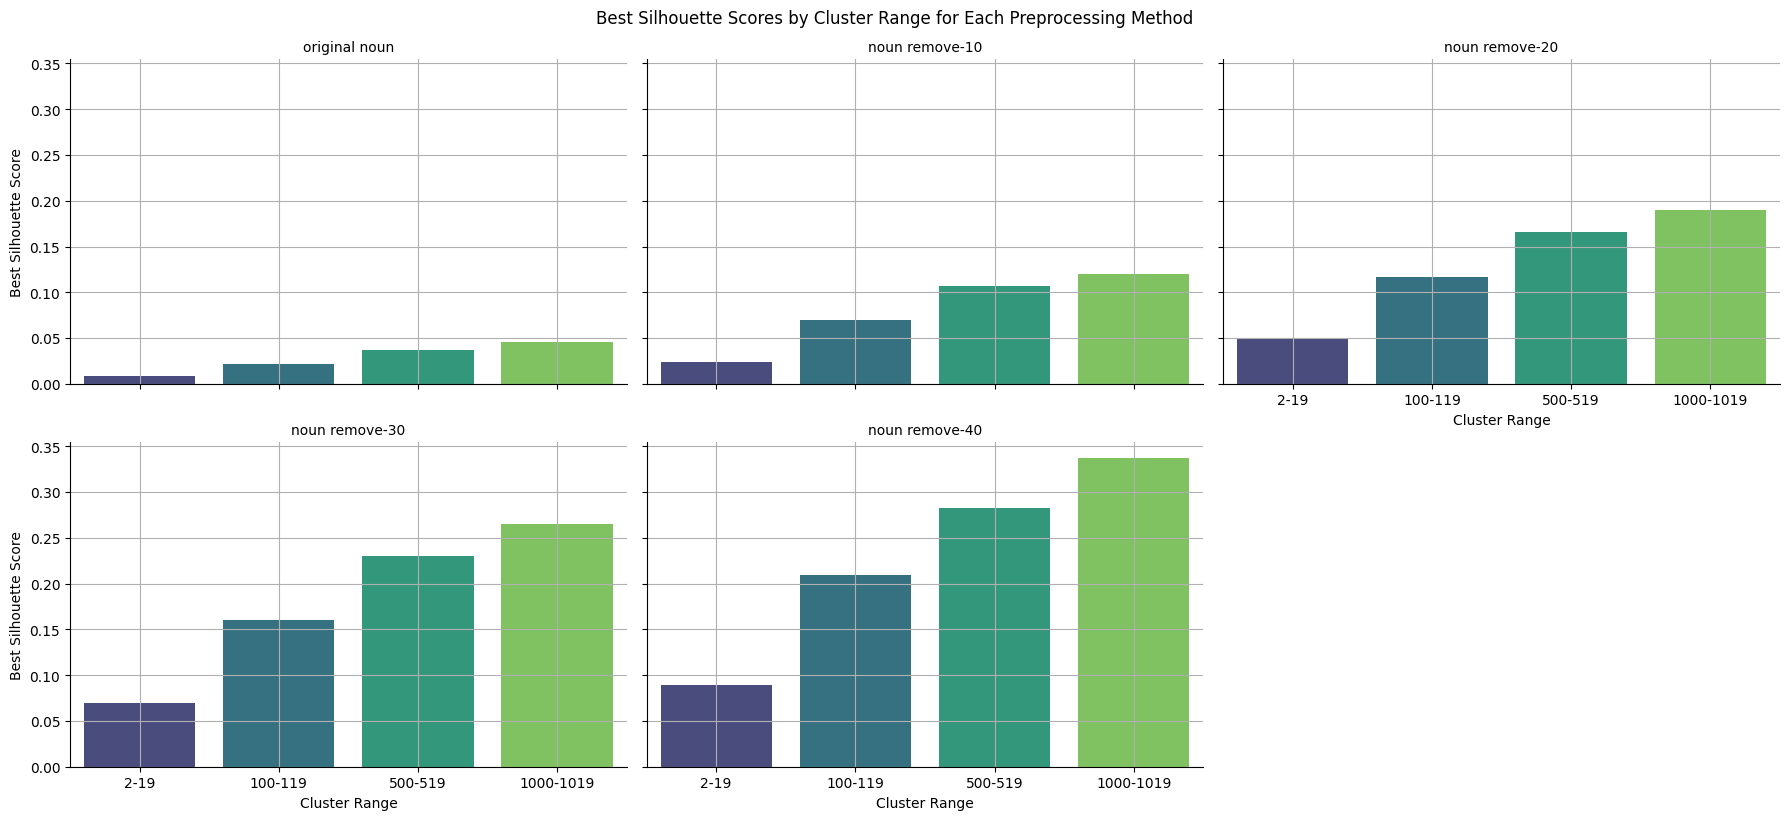

In [12]:
g = sns.FacetGrid(
    results_df,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="best_silhouette_score", palette="viridis", hue="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Best Silhouette Score")
g.figure.suptitle("Best Silhouette Scores by Cluster Range for Each Preprocessing Method", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

### Facet grid plot to visualize the distribution of average silhoutte scores over cluster range for each preprocessing method

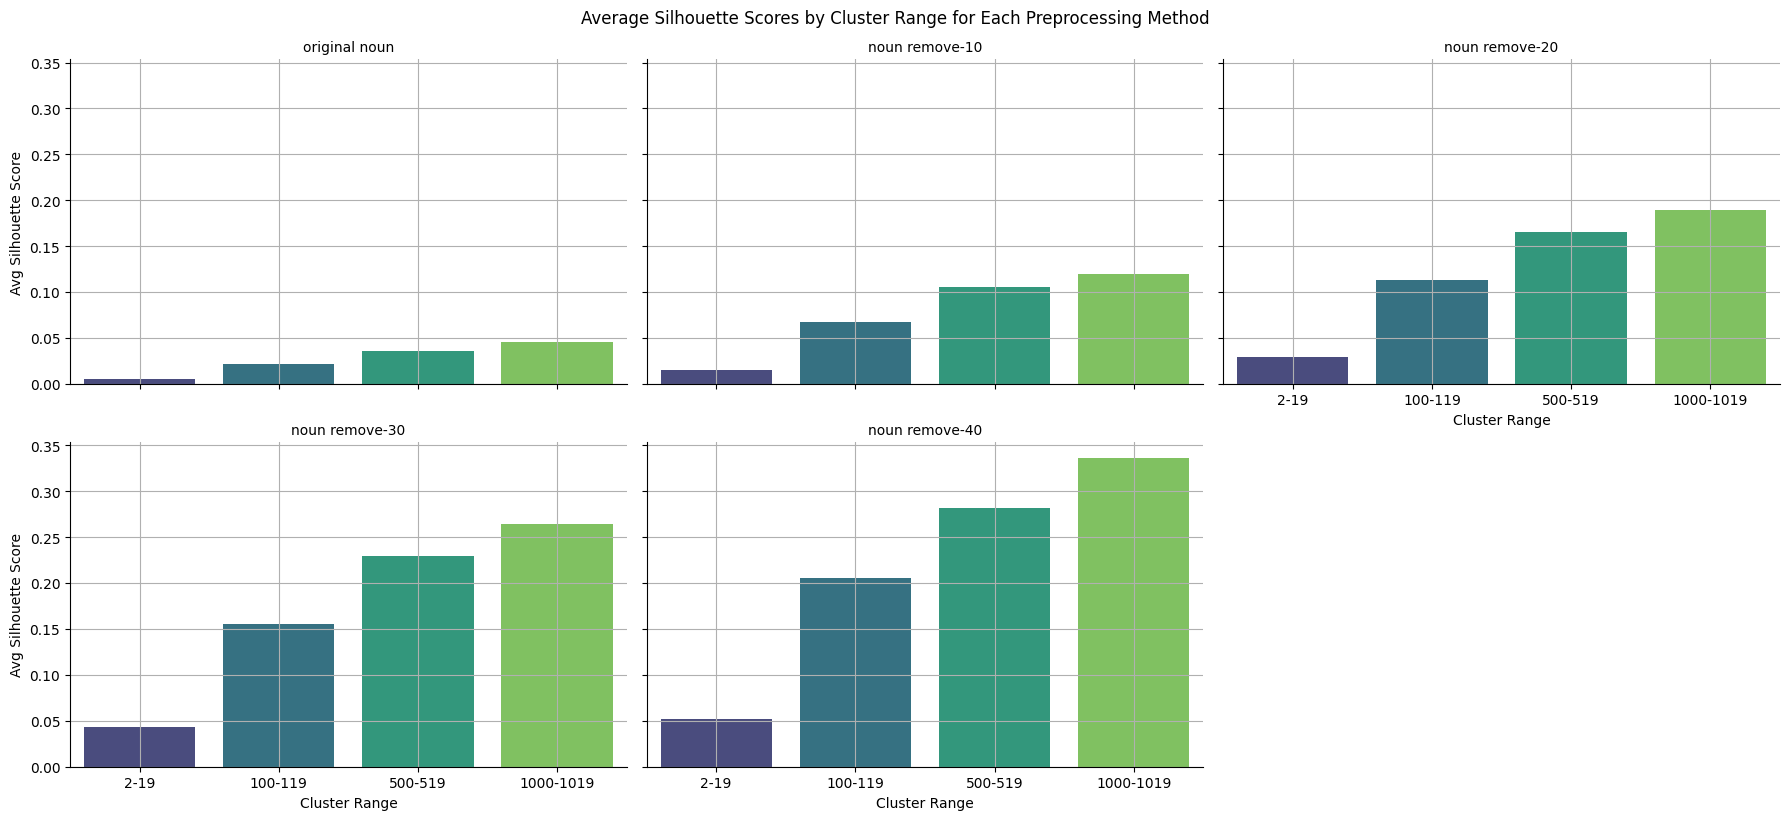

In [13]:
g = sns.FacetGrid(
    results_df,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="avg_silhouette_score", palette="viridis", hue="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Avg Silhouette Score")
g.figure.suptitle("Average Silhouette Scores by Cluster Range for Each Preprocessing Method", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

# Choose the Best Preprocessing Method and Continue Analysis by Clustering

In [4]:
def show_cluster(column_name, cluster_number):
    pd.set_option('display.max_colwidth', None)

    # Show some product examples from each cluster
    for n_clusters in range(cluster_number):
        print(f"\nExamples of products in Cluster {n_clusters}:")
        print(df[df[column_name] == n_clusters][['name']].head(5))

    # Reset display option
    pd.reset_option('display.max_colwidth')

In [5]:
from wordcloud import WordCloud

def show_wordclouds(column_name, cluster_number):
    for n_clusters in range(cluster_number):
        # get the data in the cluster
        cluster_data = df[df[column_name] == n_clusters]['name'].dropna().tolist()
        text = " ".join(cluster_data)  # join all the text in the cluster

        # Generate WordCloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Show WordCloud
        plt.figure(figsize=(6, 3))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for Cluster {n_clusters}", fontsize=16)
        plt.show()

## Find Optimum K Cluster using Elbow Method

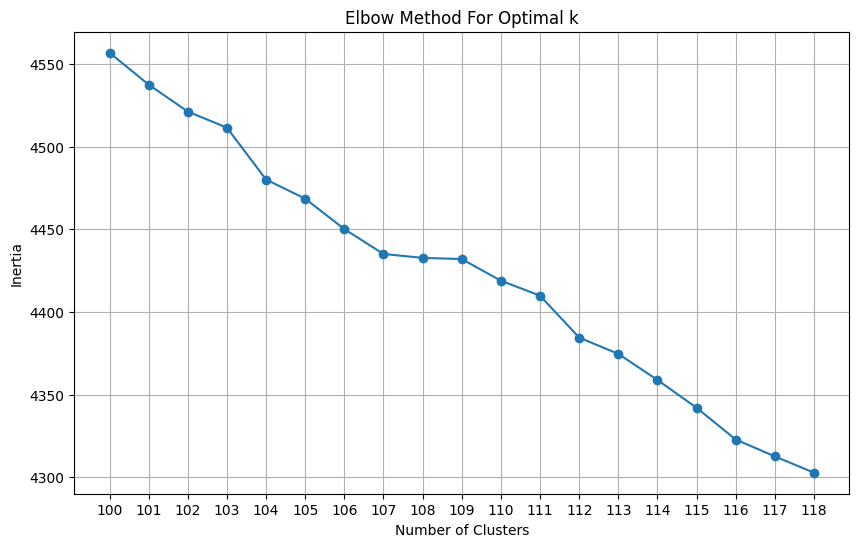

In [7]:
inertia_values = []
cluster_range = range(100, 119)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['noun remove-40'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

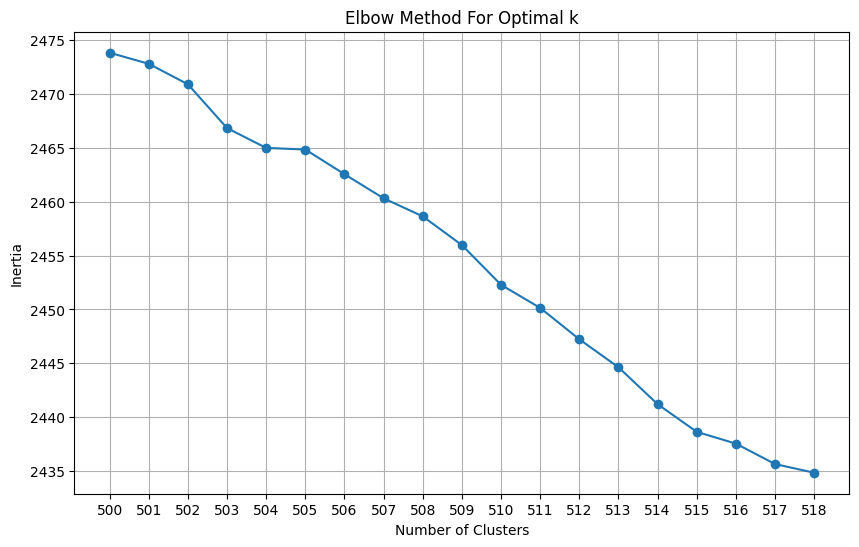

In [8]:
inertia_values = []
cluster_range = range(500, 519)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['noun remove-40'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

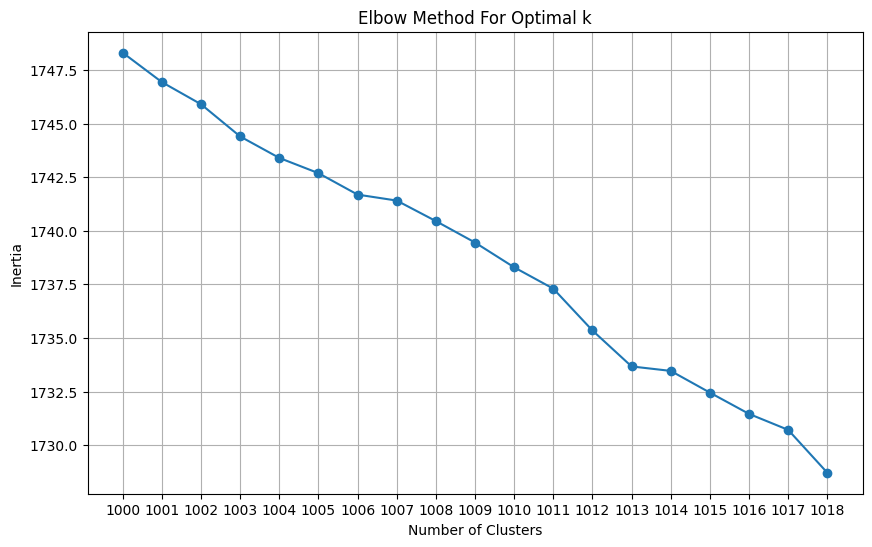

In [9]:
inertia_values = []
cluster_range = range(1000, 1019)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['noun remove-40'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

## Analysis Each Optimum Cluster

### Cluster 100

In [19]:
optimal_k = 108
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster100'] = kmeans.fit_predict(vectorizers['noun remove-40'])

In [20]:
show_cluster('cluster100', 10)


Examples of products in Cluster 0:
                                                                       name
3019  Milkapalooza ASI Booster / Pelancar / Penambah / Pengental ASI 60 cap
4884  Mom Uung Asi Booster Pelancar Asi Momuung Kapsul Kelor Pil BPOM Halal
6731    TORTEA Teh Pelancar ASI Booster Torbangun Herbal Untuk Ibu Menyusui

Examples of products in Cluster 1:
                                                                   name
229                            pilsket muslim warna terbaru rok plisket
239  Mybamus x Rahma.nura - Diana Skirt Khaki M17177 R47S2 - Rok Muslim
396                            ROK PRAMUKA PANJANG REMPEL MEREK SERAGAM
470                             rok cargo wanita jumbo terbaru kekinian
754                      Rok Panjang SMA Span Abu Seragam Sekolah FAJAR

Examples of products in Cluster 2:
                                                                 name
29             Muji PC Fountain Pen Set - pulpen kaligrafi / pena set
197  [FREE RAK S

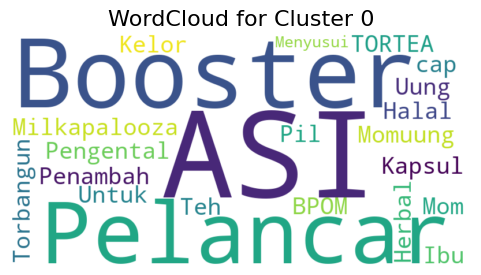

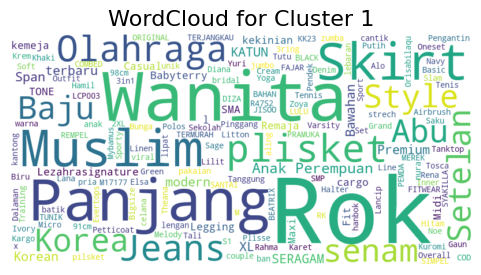

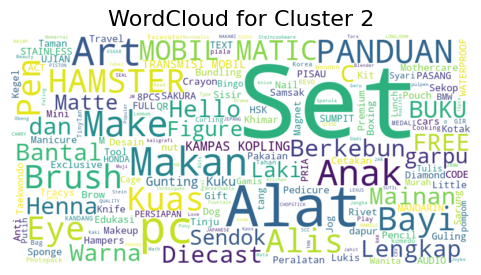

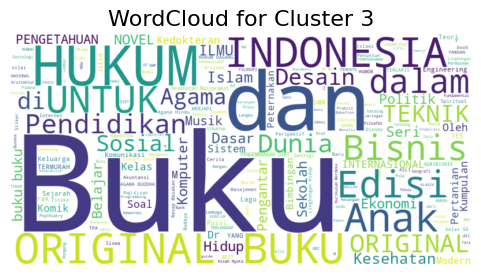

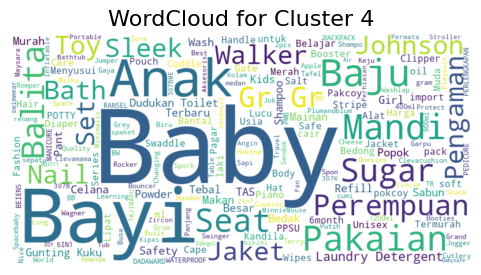

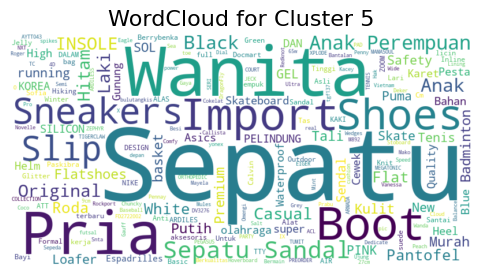

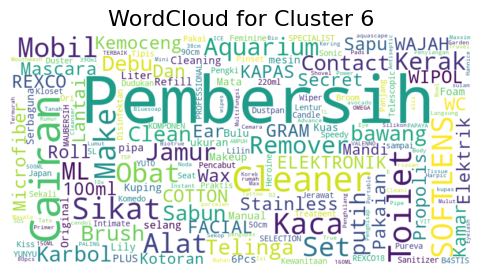

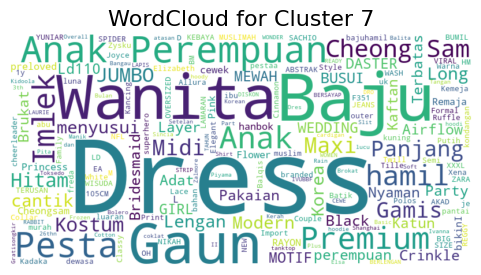

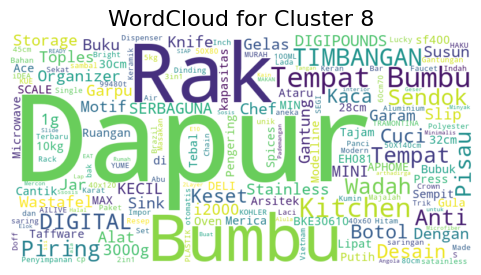

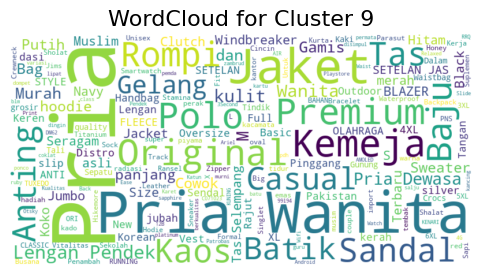

In [21]:
show_wordclouds('cluster100', 10)

### Cluster 500

In [22]:
optimal_k = 504
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster500'] = kmeans.fit_predict(vectorizers['noun remove-40'])

In [23]:
show_cluster('cluster500', 10)


Examples of products in Cluster 0:
                                                                       name
3019  Milkapalooza ASI Booster / Pelancar / Penambah / Pengental ASI 60 cap
4884  Mom Uung Asi Booster Pelancar Asi Momuung Kapsul Kelor Pil BPOM Halal
6731    TORTEA Teh Pelancar ASI Booster Torbangun Herbal Untuk Ibu Menyusui

Examples of products in Cluster 1:
                                                                        name
470                                  rok cargo wanita jumbo terbaru kekinian
1208                  Rok Linen Korean Style Rok A Line Wanita (S1-028-1076)
1260  Petticoat bridal Panjang l Rok Dalaman Gaun Pengantin (3ring) - LCP003
2636                                          Rok Hamil Maxi strech 131 Navy
3985    Setelan senam wanita Rok /baju senam /pakaian olahraga / Tosca Hitam

Examples of products in Cluster 2:
                                                                                     name
1295  ZACRO Penutup Kaca depan Mobil

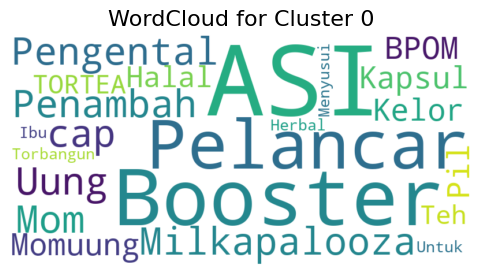

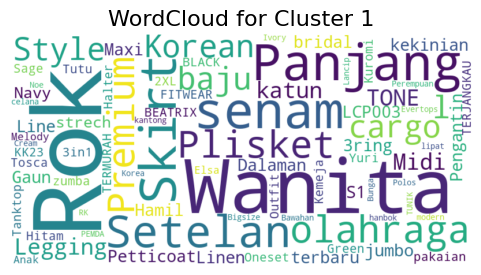

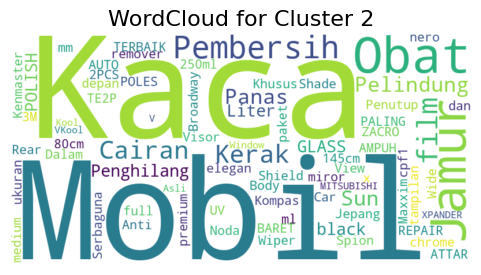

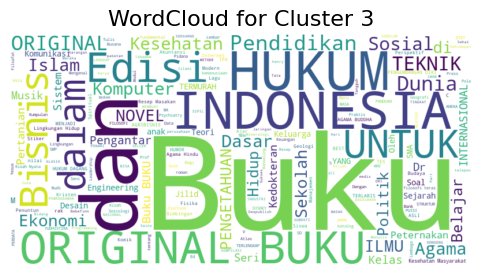

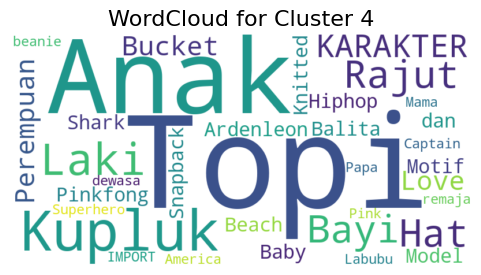

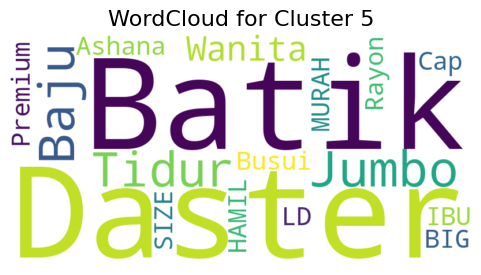

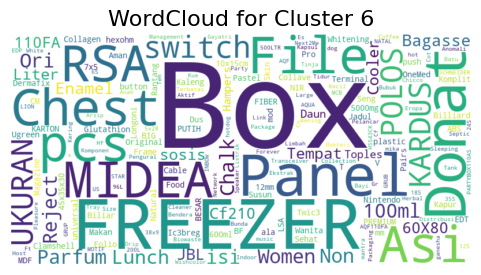

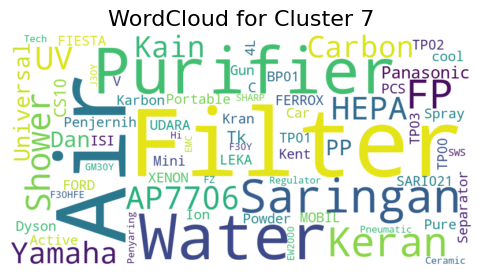

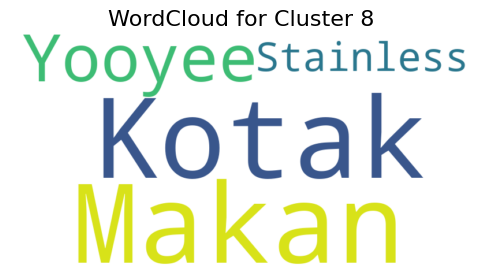

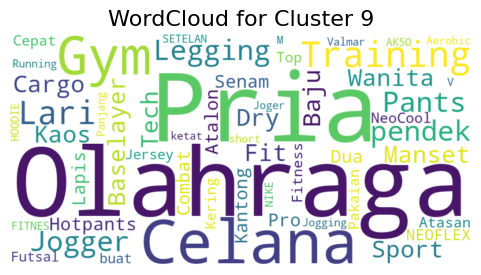

In [24]:
show_wordclouds('cluster500', 10)

### Cluster 1000

In [25]:
optimal_k = 1013
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster1000'] = kmeans.fit_predict(vectorizers['noun remove-40'])

In [26]:
show_cluster('cluster1000', 10)


Examples of products in Cluster 0:
                                                                       name
3019  Milkapalooza ASI Booster / Pelancar / Penambah / Pengental ASI 60 cap
4884  Mom Uung Asi Booster Pelancar Asi Momuung Kapsul Kelor Pil BPOM Halal
6731    TORTEA Teh Pelancar ASI Booster Torbangun Herbal Untuk Ibu Menyusui

Examples of products in Cluster 1:
                                                                                              name
470                                                        rok cargo wanita jumbo terbaru kekinian
1208                                        Rok Linen Korean Style Rok A Line Wanita (S1-028-1076)
4008                      Rok + Legging Olahraga Wanita FITWEAR BEATRIX 2 TONE - 2 TONE BLACK, 2XL
5358                           Rok legging panjang olahraga senam zumba wanita TERJANGKAU TERMURAH
5394  Oneset 3in1 Wanita (Kemeja Sage Green, Tanktop Halter, Rok Cargo) Outfit Korean Style - KK23

Examples of products in Clust

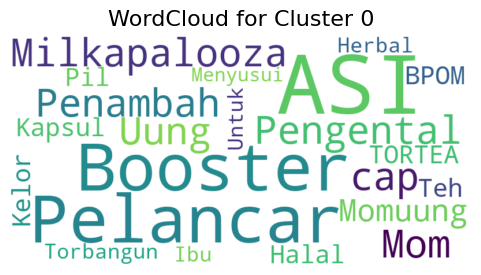

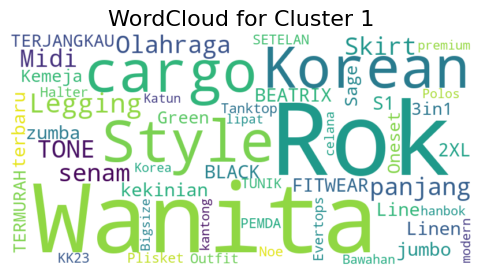

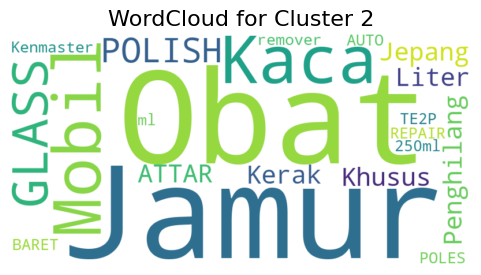

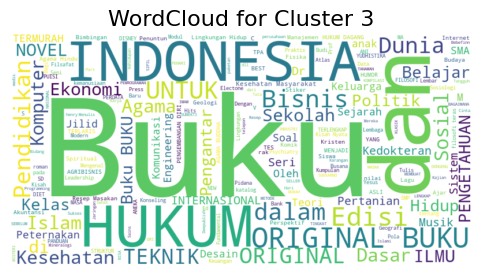

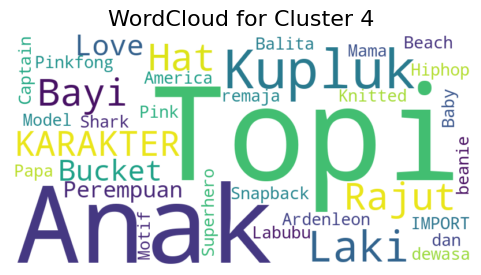

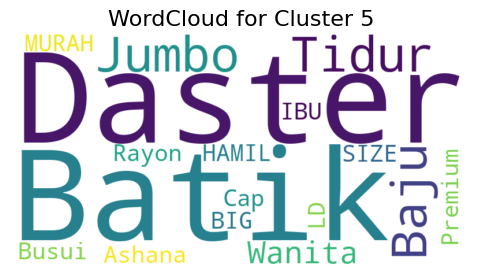

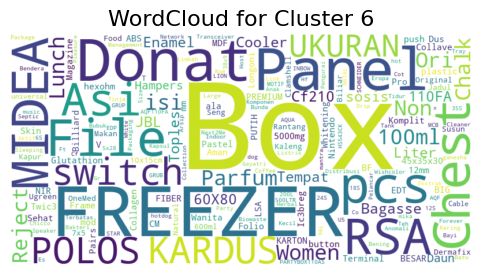

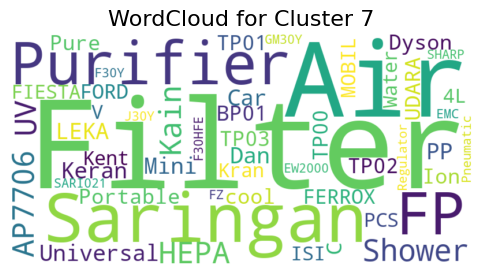

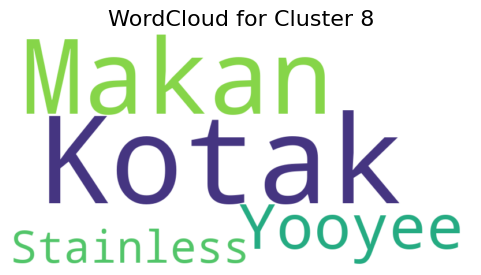

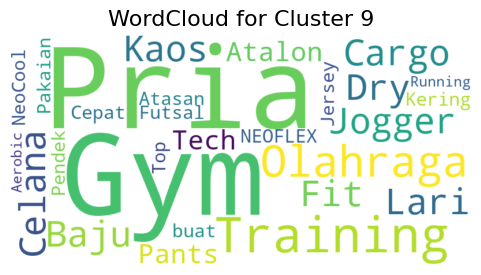

In [27]:
show_wordclouds('cluster1000', 10)